In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('..')
from models import DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference, EMDensityEstimator
from utils.color_visual import *

(256, 197, 3)


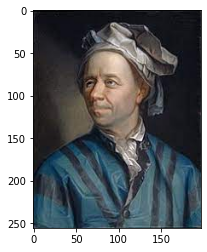

In [2]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)
print(rgb.shape)

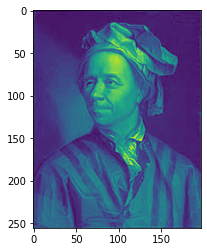

In [35]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = rgb2gray(rgb)
plt.imshow(torch.tensor(grey))

In [38]:
vector_density = torch.tensor(grey.flatten())
vector_density = vector_density/torch.sum(vector_density)

In [55]:
l, L = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
samples = torch.cat([(categorical_samples//L).unsqueeze(-1), (categorical_samples%L).unsqueeze(-1)], dim = -1) + 0.1*torch.randn([num_samples,2])

<ipython-input-55-6ffb22cb6252>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  samples = torch.cat([(categorical_samples//L).unsqueeze(-1), (categorical_samples%L).unsqueeze(-1)], dim = -1) + 0.1*torch.randn([num_samples,2])


In [56]:
print(samples.shape)

torch.Size([100000, 2])


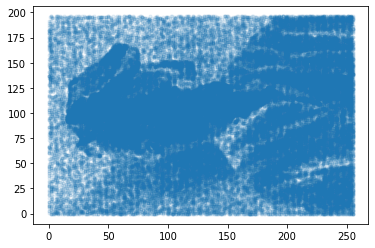

In [57]:
plt.scatter(samples[:,0], samples[:, 1], alpha = .1, marker = '.')

In [58]:
structure = [[RealNVPDensityEstimatorLayer,[128,128]],[RealNVPDensityEstimatorLayer,[128,128]],[RealNVPDensityEstimatorLayer,[128,128]]]
dif = EMDensityEstimator(samples.float(),100)
loss_values = dif.train(500)

  0%|                                                                                                                                                                                                             | 0/500 [00:00<?, ?it/s]

torch.Size([100000, 100, 2, 1])


  0%|▎                                                                                                                                                                         | 1/500 [00:01<09:16,  1.12s/it, loss = 10.745137214660645]

torch.Size([100000, 100, 2, 1])


  0%|▋                                                                                                                                                                         | 2/500 [00:02<08:26,  1.02s/it, loss = 10.699413299560547]

torch.Size([100000, 100, 2, 1])


  1%|█                                                                                                                                                                         | 3/500 [00:03<08:56,  1.08s/it, loss = 10.685785293579102]

torch.Size([100000, 100, 2, 1])


  1%|█▎                                                                                                                                                                        | 4/500 [00:04<09:17,  1.12s/it, loss = 10.679352760314941]

torch.Size([100000, 100, 2, 1])


  1%|█▋                                                                                                                                                                        | 5/500 [00:05<09:09,  1.11s/it, loss = 10.675569534301758]

torch.Size([100000, 100, 2, 1])


  1%|██                                                                                                                                                                        | 6/500 [00:06<09:21,  1.14s/it, loss = 10.673020362854004]

torch.Size([100000, 100, 2, 1])


  1%|██▍                                                                                                                                                                        | 7/500 [00:07<09:21,  1.14s/it, loss = 10.67113208770752]

torch.Size([100000, 100, 2, 1])


  2%|██▋                                                                                                                                                                       | 8/500 [00:08<09:08,  1.12s/it, loss = 10.669634819030762]

torch.Size([100000, 100, 2, 1])


  2%|███                                                                                                                                                                       | 9/500 [00:09<09:02,  1.11s/it, loss = 10.668390274047852]

torch.Size([100000, 100, 2, 1])


  2%|███▍                                                                                                                                                                     | 10/500 [00:11<09:04,  1.11s/it, loss = 10.667318344116211]

torch.Size([100000, 100, 2, 1])


  2%|███▋                                                                                                                                                                     | 11/500 [00:12<09:01,  1.11s/it, loss = 10.666370391845703]

torch.Size([100000, 100, 2, 1])


  2%|████                                                                                                                                                                     | 12/500 [00:13<09:04,  1.12s/it, loss = 10.665514945983887]

torch.Size([100000, 100, 2, 1])


  3%|████▍                                                                                                                                                                    | 13/500 [00:14<09:04,  1.12s/it, loss = 10.664737701416016]

torch.Size([100000, 100, 2, 1])


  3%|████▋                                                                                                                                                                    | 14/500 [00:15<09:02,  1.12s/it, loss = 10.664021492004395]

torch.Size([100000, 100, 2, 1])


  3%|█████                                                                                                                                                                    | 15/500 [00:16<09:14,  1.14s/it, loss = 10.663357734680176]

torch.Size([100000, 100, 2, 1])


  3%|█████▍                                                                                                                                                                   | 16/500 [00:17<09:15,  1.15s/it, loss = 10.662741661071777]

torch.Size([100000, 100, 2, 1])


  3%|█████▊                                                                                                                                                                    | 17/500 [00:19<09:18,  1.16s/it, loss = 10.66217041015625]

torch.Size([100000, 100, 2, 1])


  4%|██████                                                                                                                                                                   | 18/500 [00:20<09:15,  1.15s/it, loss = 10.661640167236328]

torch.Size([100000, 100, 2, 1])


  4%|██████▍                                                                                                                                                                  | 19/500 [00:21<09:18,  1.16s/it, loss = 10.661149024963379]

torch.Size([100000, 100, 2, 1])


  4%|██████▊                                                                                                                                                                  | 20/500 [00:22<09:22,  1.17s/it, loss = 10.660690307617188]

torch.Size([100000, 100, 2, 1])


  4%|███████                                                                                                                                                                  | 21/500 [00:23<09:25,  1.18s/it, loss = 10.660262107849121]

torch.Size([100000, 100, 2, 1])


  4%|███████▍                                                                                                                                                                 | 22/500 [00:24<09:11,  1.15s/it, loss = 10.659862518310547]

torch.Size([100000, 100, 2, 1])


  5%|███████▊                                                                                                                                                                 | 23/500 [00:26<09:05,  1.14s/it, loss = 10.659482955932617]

torch.Size([100000, 100, 2, 1])


  5%|████████                                                                                                                                                                 | 24/500 [00:27<09:24,  1.19s/it, loss = 10.659122467041016]

torch.Size([100000, 100, 2, 1])


  5%|████████▌                                                                                                                                                                 | 25/500 [00:28<09:26,  1.19s/it, loss = 10.65877914428711]

torch.Size([100000, 100, 2, 1])


  5%|████████▊                                                                                                                                                                | 26/500 [00:29<09:32,  1.21s/it, loss = 10.658449172973633]

torch.Size([100000, 100, 2, 1])


  5%|█████████▏                                                                                                                                                               | 27/500 [00:30<09:28,  1.20s/it, loss = 10.658132553100586]

torch.Size([100000, 100, 2, 1])


  6%|█████████▍                                                                                                                                                               | 28/500 [00:32<09:18,  1.18s/it, loss = 10.657825469970703]

torch.Size([100000, 100, 2, 1])


  6%|█████████▊                                                                                                                                                               | 29/500 [00:33<09:14,  1.18s/it, loss = 10.657529830932617]

torch.Size([100000, 100, 2, 1])


  6%|██████████▏                                                                                                                                                              | 30/500 [00:34<09:11,  1.17s/it, loss = 10.657243728637695]

torch.Size([100000, 100, 2, 1])


  6%|██████████▍                                                                                                                                                              | 31/500 [00:35<09:01,  1.15s/it, loss = 10.656965255737305]

torch.Size([100000, 100, 2, 1])


  6%|██████████▊                                                                                                                                                              | 32/500 [00:36<08:54,  1.14s/it, loss = 10.656697273254395]

torch.Size([100000, 100, 2, 1])


  7%|███████████▎                                                                                                                                                               | 33/500 [00:37<08:42,  1.12s/it, loss = 10.6564359664917]

torch.Size([100000, 100, 2, 1])


  7%|███████████▍                                                                                                                                                             | 34/500 [00:38<08:45,  1.13s/it, loss = 10.656184196472168]

torch.Size([100000, 100, 2, 1])


  7%|███████████▊                                                                                                                                                             | 35/500 [00:40<08:49,  1.14s/it, loss = 10.655937194824219]

torch.Size([100000, 100, 2, 1])


  7%|████████████▎                                                                                                                                                              | 36/500 [00:41<08:39,  1.12s/it, loss = 10.6556978225708]

torch.Size([100000, 100, 2, 1])


  7%|████████████▌                                                                                                                                                            | 37/500 [00:42<08:36,  1.12s/it, loss = 10.655464172363281]

torch.Size([100000, 100, 2, 1])


  8%|████████████▊                                                                                                                                                            | 38/500 [00:43<08:34,  1.11s/it, loss = 10.655231475830078]

torch.Size([100000, 100, 2, 1])


  8%|█████████████▎                                                                                                                                                            | 39/500 [00:44<08:33,  1.11s/it, loss = 10.65500545501709]

torch.Size([100000, 100, 2, 1])


  8%|█████████████▌                                                                                                                                                           | 40/500 [00:45<08:17,  1.08s/it, loss = 10.654781341552734]

torch.Size([100000, 100, 2, 1])


  8%|█████████████▊                                                                                                                                                           | 41/500 [00:46<08:24,  1.10s/it, loss = 10.654560089111328]

torch.Size([100000, 100, 2, 1])


  8%|██████████████▏                                                                                                                                                          | 42/500 [00:47<08:32,  1.12s/it, loss = 10.654342651367188]

torch.Size([100000, 100, 2, 1])


  9%|██████████████▌                                                                                                                                                          | 43/500 [00:48<08:27,  1.11s/it, loss = 10.654125213623047]

torch.Size([100000, 100, 2, 1])


  9%|██████████████▊                                                                                                                                                          | 44/500 [00:49<08:15,  1.09s/it, loss = 10.653909683227539]

torch.Size([100000, 100, 2, 1])


  9%|███████████████▏                                                                                                                                                         | 45/500 [00:50<08:12,  1.08s/it, loss = 10.653695106506348]

torch.Size([100000, 100, 2, 1])


  9%|███████████████▋                                                                                                                                                          | 46/500 [00:52<08:21,  1.10s/it, loss = 10.65347957611084]

torch.Size([100000, 100, 2, 1])


  9%|███████████████▉                                                                                                                                                         | 47/500 [00:53<08:14,  1.09s/it, loss = 10.653264045715332]

torch.Size([100000, 100, 2, 1])


 10%|████████████████▏                                                                                                                                                        | 48/500 [00:54<08:19,  1.11s/it, loss = 10.653044700622559]

torch.Size([100000, 100, 2, 1])


 10%|████████████████▌                                                                                                                                                        | 49/500 [00:55<08:18,  1.11s/it, loss = 10.652822494506836]

torch.Size([100000, 100, 2, 1])


 10%|████████████████▉                                                                                                                                                        | 50/500 [00:56<08:21,  1.12s/it, loss = 10.652597427368164]

torch.Size([100000, 100, 2, 1])


 10%|█████████████████▏                                                                                                                                                       | 51/500 [00:57<08:29,  1.13s/it, loss = 10.652368545532227]

torch.Size([100000, 100, 2, 1])


 10%|█████████████████▌                                                                                                                                                       | 52/500 [00:58<08:25,  1.13s/it, loss = 10.652134895324707]

torch.Size([100000, 100, 2, 1])


 11%|█████████████████▉                                                                                                                                                       | 53/500 [00:59<08:11,  1.10s/it, loss = 10.651897430419922]

torch.Size([100000, 100, 2, 1])


 11%|██████████████████▎                                                                                                                                                       | 54/500 [01:00<08:04,  1.09s/it, loss = 10.65165901184082]

torch.Size([100000, 100, 2, 1])


 11%|██████████████████▌                                                                                                                                                      | 55/500 [01:02<08:16,  1.12s/it, loss = 10.651418685913086]

torch.Size([100000, 100, 2, 1])


 11%|██████████████████▉                                                                                                                                                      | 56/500 [01:03<08:09,  1.10s/it, loss = 10.651178359985352]

torch.Size([100000, 100, 2, 1])


 11%|███████████████████▍                                                                                                                                                      | 57/500 [01:04<08:12,  1.11s/it, loss = 10.65093994140625]

torch.Size([100000, 100, 2, 1])


 12%|███████████████████▌                                                                                                                                                     | 58/500 [01:05<08:13,  1.12s/it, loss = 10.650705337524414]

torch.Size([100000, 100, 2, 1])


 12%|███████████████████▉                                                                                                                                                     | 59/500 [01:06<08:06,  1.10s/it, loss = 10.650477409362793]

torch.Size([100000, 100, 2, 1])


 12%|████████████████████▎                                                                                                                                                    | 60/500 [01:07<08:06,  1.11s/it, loss = 10.650256156921387]

torch.Size([100000, 100, 2, 1])


 12%|████████████████████▌                                                                                                                                                    | 61/500 [01:08<08:00,  1.10s/it, loss = 10.650042533874512]

torch.Size([100000, 100, 2, 1])


 12%|████████████████████▉                                                                                                                                                    | 62/500 [01:09<08:07,  1.11s/it, loss = 10.649837493896484]

torch.Size([100000, 100, 2, 1])


 13%|█████████████████████▎                                                                                                                                                   | 63/500 [01:11<08:20,  1.14s/it, loss = 10.649643898010254]

torch.Size([100000, 100, 2, 1])


 13%|█████████████████████▋                                                                                                                                                   | 64/500 [01:12<08:34,  1.18s/it, loss = 10.649457931518555]

torch.Size([100000, 100, 2, 1])


 13%|█████████████████████▉                                                                                                                                                   | 65/500 [01:13<08:38,  1.19s/it, loss = 10.649282455444336]

torch.Size([100000, 100, 2, 1])


 13%|██████████████████████▎                                                                                                                                                  | 66/500 [01:14<08:40,  1.20s/it, loss = 10.649117469787598]

torch.Size([100000, 100, 2, 1])


 13%|██████████████████████▊                                                                                                                                                   | 67/500 [01:15<08:30,  1.18s/it, loss = 10.64896011352539]

torch.Size([100000, 100, 2, 1])


 14%|██████████████████████▉                                                                                                                                                  | 68/500 [01:17<08:36,  1.20s/it, loss = 10.648812294006348]

torch.Size([100000, 100, 2, 1])


 14%|███████████████████████▍                                                                                                                                                  | 69/500 [01:18<08:42,  1.21s/it, loss = 10.64867115020752]

torch.Size([100000, 100, 2, 1])


 14%|███████████████████████▋                                                                                                                                                 | 70/500 [01:19<08:37,  1.20s/it, loss = 10.648538589477539]

torch.Size([100000, 100, 2, 1])


 14%|███████████████████████▉                                                                                                                                                 | 71/500 [01:20<08:41,  1.22s/it, loss = 10.648409843444824]

torch.Size([100000, 100, 2, 1])


 14%|████████████████████████▎                                                                                                                                                | 72/500 [01:22<08:41,  1.22s/it, loss = 10.648285865783691]

torch.Size([100000, 100, 2, 1])


 15%|████████████████████████▋                                                                                                                                                | 73/500 [01:23<08:46,  1.23s/it, loss = 10.648170471191406]

torch.Size([100000, 100, 2, 1])


 15%|█████████████████████████                                                                                                                                                | 74/500 [01:24<08:47,  1.24s/it, loss = 10.648059844970703]

torch.Size([100000, 100, 2, 1])


 15%|█████████████████████████▎                                                                                                                                               | 75/500 [01:25<08:47,  1.24s/it, loss = 10.647954940795898]

torch.Size([100000, 100, 2, 1])


 15%|█████████████████████████▋                                                                                                                                               | 76/500 [01:27<08:49,  1.25s/it, loss = 10.647857666015625]

torch.Size([100000, 100, 2, 1])


 15%|██████████████████████████                                                                                                                                               | 77/500 [01:28<08:41,  1.23s/it, loss = 10.647761344909668]

torch.Size([100000, 100, 2, 1])


 16%|██████████████████████████▎                                                                                                                                              | 78/500 [01:29<08:35,  1.22s/it, loss = 10.647672653198242]

torch.Size([100000, 100, 2, 1])


 16%|██████████████████████████▋                                                                                                                                              | 79/500 [01:30<08:37,  1.23s/it, loss = 10.647589683532715]

torch.Size([100000, 100, 2, 1])


 16%|███████████████████████████                                                                                                                                              | 80/500 [01:31<08:33,  1.22s/it, loss = 10.647509574890137]

torch.Size([100000, 100, 2, 1])


 16%|███████████████████████████▍                                                                                                                                             | 81/500 [01:33<08:19,  1.19s/it, loss = 10.647435188293457]

torch.Size([100000, 100, 2, 1])


 16%|███████████████████████████▉                                                                                                                                              | 82/500 [01:34<08:19,  1.20s/it, loss = 10.64736270904541]

torch.Size([100000, 100, 2, 1])


 17%|████████████████████████████                                                                                                                                             | 83/500 [01:35<08:18,  1.20s/it, loss = 10.647294998168945]

torch.Size([100000, 100, 2, 1])


 17%|████████████████████████████▌                                                                                                                                             | 84/500 [01:36<08:20,  1.20s/it, loss = 10.64723014831543]

torch.Size([100000, 100, 2, 1])


 17%|████████████████████████████▋                                                                                                                                            | 85/500 [01:37<08:19,  1.20s/it, loss = 10.647163391113281]

torch.Size([100000, 100, 2, 1])


 17%|█████████████████████████████                                                                                                                                            | 86/500 [01:39<08:15,  1.20s/it, loss = 10.647102355957031]

torch.Size([100000, 100, 2, 1])


 17%|█████████████████████████████▍                                                                                                                                           | 87/500 [01:40<08:21,  1.21s/it, loss = 10.647042274475098]

torch.Size([100000, 100, 2, 1])


 18%|█████████████████████████████▋                                                                                                                                           | 88/500 [01:41<08:22,  1.22s/it, loss = 10.646982192993164]

torch.Size([100000, 100, 2, 1])


 18%|██████████████████████████████▎                                                                                                                                           | 89/500 [01:42<08:28,  1.24s/it, loss = 10.64692211151123]

torch.Size([100000, 100, 2, 1])


 18%|██████████████████████████████▍                                                                                                                                          | 90/500 [01:44<08:31,  1.25s/it, loss = 10.646865844726562]

torch.Size([100000, 100, 2, 1])


 18%|██████████████████████████████▊                                                                                                                                          | 91/500 [01:45<08:33,  1.26s/it, loss = 10.646808624267578]

torch.Size([100000, 100, 2, 1])


 18%|███████████████████████████████                                                                                                                                          | 92/500 [01:46<08:32,  1.26s/it, loss = 10.646750450134277]

torch.Size([100000, 100, 2, 1])


 19%|███████████████████████████████▍                                                                                                                                         | 93/500 [01:47<08:26,  1.24s/it, loss = 10.646696090698242]

torch.Size([100000, 100, 2, 1])


 19%|███████████████████████████████▊                                                                                                                                         | 94/500 [01:49<08:16,  1.22s/it, loss = 10.646639823913574]

torch.Size([100000, 100, 2, 1])


 19%|████████████████████████████████                                                                                                                                         | 95/500 [01:50<08:08,  1.21s/it, loss = 10.646585464477539]

torch.Size([100000, 100, 2, 1])


 19%|████████████████████████████████▍                                                                                                                                        | 96/500 [01:51<08:14,  1.22s/it, loss = 10.646529197692871]

torch.Size([100000, 100, 2, 1])


 19%|████████████████████████████████▊                                                                                                                                        | 97/500 [01:52<08:17,  1.23s/it, loss = 10.646474838256836]

torch.Size([100000, 100, 2, 1])


 20%|█████████████████████████████████                                                                                                                                        | 98/500 [01:53<08:20,  1.24s/it, loss = 10.646421432495117]

torch.Size([100000, 100, 2, 1])


 20%|█████████████████████████████████▍                                                                                                                                       | 99/500 [01:55<08:09,  1.22s/it, loss = 10.646367073059082]

torch.Size([100000, 100, 2, 1])


 20%|█████████████████████████████████▊                                                                                                                                       | 100/500 [01:56<08:06,  1.22s/it, loss = 10.64631462097168]

torch.Size([100000, 100, 2, 1])


 20%|██████████████████████████████████▏                                                                                                                                      | 101/500 [01:57<08:04,  1.22s/it, loss = 10.64626407623291]

torch.Size([100000, 100, 2, 1])


 20%|██████████████████████████████████▎                                                                                                                                     | 102/500 [01:58<08:03,  1.21s/it, loss = 10.646212577819824]

torch.Size([100000, 100, 2, 1])


 21%|██████████████████████████████████▌                                                                                                                                     | 103/500 [01:59<07:58,  1.21s/it, loss = 10.646160125732422]

torch.Size([100000, 100, 2, 1])


 21%|██████████████████████████████████▉                                                                                                                                     | 104/500 [02:01<07:50,  1.19s/it, loss = 10.646109580993652]

torch.Size([100000, 100, 2, 1])


 21%|███████████████████████████████████▎                                                                                                                                    | 105/500 [02:02<07:50,  1.19s/it, loss = 10.646059036254883]

torch.Size([100000, 100, 2, 1])


 21%|███████████████████████████████████▌                                                                                                                                    | 106/500 [02:03<07:55,  1.21s/it, loss = 10.646010398864746]

torch.Size([100000, 100, 2, 1])


 21%|███████████████████████████████████▉                                                                                                                                    | 107/500 [02:04<07:49,  1.20s/it, loss = 10.645960807800293]

torch.Size([100000, 100, 2, 1])


 22%|████████████████████████████████████▎                                                                                                                                   | 108/500 [02:05<07:48,  1.20s/it, loss = 10.645912170410156]

torch.Size([100000, 100, 2, 1])


 22%|████████████████████████████████████▌                                                                                                                                   | 109/500 [02:07<07:42,  1.18s/it, loss = 10.645865440368652]

torch.Size([100000, 100, 2, 1])


 22%|████████████████████████████████████▉                                                                                                                                   | 110/500 [02:08<07:41,  1.18s/it, loss = 10.645814895629883]

torch.Size([100000, 100, 2, 1])


 22%|█████████████████████████████████████▌                                                                                                                                   | 111/500 [02:09<07:43,  1.19s/it, loss = 10.64576530456543]

torch.Size([100000, 100, 2, 1])


 22%|█████████████████████████████████████▋                                                                                                                                  | 112/500 [02:10<07:49,  1.21s/it, loss = 10.645716667175293]

torch.Size([100000, 100, 2, 1])


 23%|█████████████████████████████████████▉                                                                                                                                  | 113/500 [02:11<07:46,  1.21s/it, loss = 10.645662307739258]

torch.Size([100000, 100, 2, 1])


 23%|██████████████████████████████████████▎                                                                                                                                 | 114/500 [02:13<07:51,  1.22s/it, loss = 10.645608901977539]

torch.Size([100000, 100, 2, 1])


 23%|██████████████████████████████████████▋                                                                                                                                 | 115/500 [02:14<07:46,  1.21s/it, loss = 10.645554542541504]

torch.Size([100000, 100, 2, 1])


 23%|██████████████████████████████████████▉                                                                                                                                 | 116/500 [02:15<07:44,  1.21s/it, loss = 10.645495414733887]

torch.Size([100000, 100, 2, 1])


 23%|███████████████████████████████████████▎                                                                                                                                | 117/500 [02:16<07:43,  1.21s/it, loss = 10.645432472229004]

torch.Size([100000, 100, 2, 1])


 24%|███████████████████████████████████████▋                                                                                                                                | 118/500 [02:18<07:48,  1.23s/it, loss = 10.645364761352539]

torch.Size([100000, 100, 2, 1])


 24%|███████████████████████████████████████▉                                                                                                                                | 119/500 [02:19<07:50,  1.24s/it, loss = 10.645294189453125]

torch.Size([100000, 100, 2, 1])


 24%|████████████████████████████████████████▎                                                                                                                               | 120/500 [02:20<07:47,  1.23s/it, loss = 10.645215034484863]

torch.Size([100000, 100, 2, 1])


 24%|████████████████████████████████████████▉                                                                                                                                | 121/500 [02:21<07:42,  1.22s/it, loss = 10.64513111114502]

torch.Size([100000, 100, 2, 1])


 24%|████████████████████████████████████████▉                                                                                                                               | 122/500 [02:22<07:38,  1.21s/it, loss = 10.645042419433594]

torch.Size([100000, 100, 2, 1])


 25%|█████████████████████████████████████████▎                                                                                                                              | 123/500 [02:24<07:28,  1.19s/it, loss = 10.644952774047852]

torch.Size([100000, 100, 2, 1])


 25%|█████████████████████████████████████████▋                                                                                                                              | 124/500 [02:25<07:25,  1.18s/it, loss = 10.644868850708008]

torch.Size([100000, 100, 2, 1])


 25%|██████████████████████████████████████████                                                                                                                              | 125/500 [02:26<07:27,  1.19s/it, loss = 10.644791603088379]

torch.Size([100000, 100, 2, 1])


 25%|██████████████████████████████████████████▎                                                                                                                             | 126/500 [02:27<07:25,  1.19s/it, loss = 10.644723892211914]

torch.Size([100000, 100, 2, 1])


 25%|██████████████████████████████████████████▉                                                                                                                              | 127/500 [02:28<07:27,  1.20s/it, loss = 10.64466381072998]

torch.Size([100000, 100, 2, 1])


 26%|███████████████████████████████████████████                                                                                                                             | 128/500 [02:29<07:18,  1.18s/it, loss = 10.644610404968262]

torch.Size([100000, 100, 2, 1])


 26%|███████████████████████████████████████████▌                                                                                                                             | 129/500 [02:31<07:24,  1.20s/it, loss = 10.64455795288086]

torch.Size([100000, 100, 2, 1])


 26%|███████████████████████████████████████████▋                                                                                                                            | 130/500 [02:32<07:14,  1.17s/it, loss = 10.644510269165039]

torch.Size([100000, 100, 2, 1])


 26%|████████████████████████████████████████████                                                                                                                            | 131/500 [02:33<07:20,  1.19s/it, loss = 10.644465446472168]

torch.Size([100000, 100, 2, 1])


 26%|████████████████████████████████████████████▌                                                                                                                            | 132/500 [02:34<07:23,  1.21s/it, loss = 10.64442253112793]

torch.Size([100000, 100, 2, 1])


 27%|████████████████████████████████████████████▋                                                                                                                           | 133/500 [02:36<07:25,  1.21s/it, loss = 10.644379615783691]

torch.Size([100000, 100, 2, 1])


 27%|█████████████████████████████████████████████                                                                                                                           | 134/500 [02:37<07:19,  1.20s/it, loss = 10.644339561462402]

torch.Size([100000, 100, 2, 1])


 27%|█████████████████████████████████████████████▋                                                                                                                           | 135/500 [02:38<07:13,  1.19s/it, loss = 10.64430046081543]

torch.Size([100000, 100, 2, 1])


 27%|█████████████████████████████████████████████▋                                                                                                                          | 136/500 [02:39<07:05,  1.17s/it, loss = 10.644257545471191]

torch.Size([100000, 100, 2, 1])


 27%|██████████████████████████████████████████████                                                                                                                          | 137/500 [02:40<06:59,  1.16s/it, loss = 10.644213676452637]

torch.Size([100000, 100, 2, 1])


 28%|██████████████████████████████████████████████▎                                                                                                                         | 138/500 [02:41<07:00,  1.16s/it, loss = 10.644164085388184]

torch.Size([100000, 100, 2, 1])


 28%|██████████████████████████████████████████████▋                                                                                                                         | 139/500 [02:42<06:58,  1.16s/it, loss = 10.644089698791504]

torch.Size([100000, 100, 2, 1])


 28%|███████████████████████████████████████████████                                                                                                                         | 140/500 [02:44<07:06,  1.18s/it, loss = 10.643935203552246]

torch.Size([100000, 100, 2, 1])


 28%|███████████████████████████████████████████████▍                                                                                                                        | 141/500 [02:45<07:12,  1.21s/it, loss = 10.643364906311035]

torch.Size([100000, 100, 2, 1])


 28%|███████████████████████████████████████████████▉                                                                                                                         | 142/500 [02:46<07:14,  1.21s/it, loss = 10.64185619354248]

torch.Size([100000, 100, 2, 1])


 29%|████████████████████████████████████████████████▎                                                                                                                        | 143/500 [02:47<07:08,  1.20s/it, loss = 10.64161205291748]

torch.Size([100000, 100, 2, 1])


 29%|████████████████████████████████████████████████▍                                                                                                                       | 144/500 [02:49<07:09,  1.21s/it, loss = 10.641557693481445]

torch.Size([100000, 100, 2, 1])


 29%|█████████████████████████████████████████████████                                                                                                                        | 145/500 [02:50<07:08,  1.21s/it, loss = 10.64151668548584]

torch.Size([100000, 100, 2, 1])


 29%|█████████████████████████████████████████████████                                                                                                                       | 146/500 [02:51<07:12,  1.22s/it, loss = 10.641477584838867]

torch.Size([100000, 100, 2, 1])


 29%|█████████████████████████████████████████████████▍                                                                                                                      | 147/500 [02:52<07:03,  1.20s/it, loss = 10.641437530517578]

torch.Size([100000, 100, 2, 1])


 30%|█████████████████████████████████████████████████▋                                                                                                                      | 148/500 [02:53<07:09,  1.22s/it, loss = 10.641397476196289]

torch.Size([100000, 100, 2, 1])


 30%|██████████████████████████████████████████████████▉                                                                                                                        | 149/500 [02:55<07:11,  1.23s/it, loss = 10.641357421875]

torch.Size([100000, 100, 2, 1])


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 150/500 [02:56<07:12,  1.24s/it, loss = 10.64132022857666]

torch.Size([100000, 100, 2, 1])


 30%|██████████████████████████████████████████████████▋                                                                                                                     | 151/500 [02:57<07:08,  1.23s/it, loss = 10.641279220581055]

torch.Size([100000, 100, 2, 1])


 30%|███████████████████████████████████████████████████                                                                                                                     | 152/500 [02:58<07:04,  1.22s/it, loss = 10.641239166259766]

torch.Size([100000, 100, 2, 1])


 31%|███████████████████████████████████████████████████▍                                                                                                                    | 153/500 [02:59<06:55,  1.20s/it, loss = 10.641197204589844]

torch.Size([100000, 100, 2, 1])


 31%|███████████████████████████████████████████████████▋                                                                                                                    | 154/500 [03:01<06:43,  1.16s/it, loss = 10.641160011291504]

torch.Size([100000, 100, 2, 1])


 31%|████████████████████████████████████████████████████                                                                                                                    | 155/500 [03:02<06:44,  1.17s/it, loss = 10.641119003295898]

torch.Size([100000, 100, 2, 1])


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 156/500 [03:03<06:43,  1.17s/it, loss = 10.64107894897461]

torch.Size([100000, 100, 2, 1])


 31%|████████████████████████████████████████████████████▊                                                                                                                   | 157/500 [03:04<06:50,  1.20s/it, loss = 10.641037940979004]

torch.Size([100000, 100, 2, 1])


 32%|█████████████████████████████████████████████████████                                                                                                                   | 158/500 [03:05<06:52,  1.21s/it, loss = 10.640997886657715]

torch.Size([100000, 100, 2, 1])


 32%|█████████████████████████████████████████████████████▍                                                                                                                  | 159/500 [03:07<06:48,  1.20s/it, loss = 10.640959739685059]

torch.Size([100000, 100, 2, 1])


 32%|██████████████████████████████████████████████████████                                                                                                                   | 160/500 [03:08<06:46,  1.20s/it, loss = 10.64091968536377]

torch.Size([100000, 100, 2, 1])


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 161/500 [03:09<06:48,  1.21s/it, loss = 10.64087963104248]

torch.Size([100000, 100, 2, 1])


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 162/500 [03:10<06:54,  1.23s/it, loss = 10.64084243774414]

torch.Size([100000, 100, 2, 1])


 33%|██████████████████████████████████████████████████████▊                                                                                                                 | 163/500 [03:11<06:45,  1.20s/it, loss = 10.640803337097168]

torch.Size([100000, 100, 2, 1])


 33%|███████████████████████████████████████████████████████                                                                                                                 | 164/500 [03:13<06:41,  1.20s/it, loss = 10.640767097473145]

torch.Size([100000, 100, 2, 1])


 33%|███████████████████████████████████████████████████████▍                                                                                                                | 165/500 [03:14<06:45,  1.21s/it, loss = 10.640729904174805]

torch.Size([100000, 100, 2, 1])


 33%|███████████████████████████████████████████████████████▊                                                                                                                | 166/500 [03:15<06:51,  1.23s/it, loss = 10.640694618225098]

torch.Size([100000, 100, 2, 1])


 33%|████████████████████████████████████████████████████████                                                                                                                | 167/500 [03:16<06:51,  1.24s/it, loss = 10.640657424926758]

torch.Size([100000, 100, 2, 1])


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 168/500 [03:18<06:49,  1.23s/it, loss = 10.640625]

torch.Size([100000, 100, 2, 1])


 34%|████████████████████████████████████████████████████████▊                                                                                                               | 169/500 [03:19<06:41,  1.21s/it, loss = 10.640589714050293]

torch.Size([100000, 100, 2, 1])


 34%|█████████████████████████████████████████████████████████                                                                                                               | 170/500 [03:20<06:37,  1.21s/it, loss = 10.640557289123535]

torch.Size([100000, 100, 2, 1])


 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 171/500 [03:21<06:35,  1.20s/it, loss = 10.640524864196777]

torch.Size([100000, 100, 2, 1])


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 172/500 [03:22<06:29,  1.19s/it, loss = 10.64049243927002]

torch.Size([100000, 100, 2, 1])


 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 173/500 [03:23<06:27,  1.19s/it, loss = 10.640462875366211]

torch.Size([100000, 100, 2, 1])


 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 174/500 [03:25<06:22,  1.17s/it, loss = 10.640432357788086]

torch.Size([100000, 100, 2, 1])


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 175/500 [03:26<06:23,  1.18s/it, loss = 10.640402793884277]

torch.Size([100000, 100, 2, 1])


 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 176/500 [03:27<06:24,  1.19s/it, loss = 10.640375137329102]

torch.Size([100000, 100, 2, 1])


 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 177/500 [03:28<06:21,  1.18s/it, loss = 10.640347480773926]

torch.Size([100000, 100, 2, 1])


 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 178/500 [03:29<06:19,  1.18s/it, loss = 10.640318870544434]

torch.Size([100000, 100, 2, 1])


 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 179/500 [03:31<06:15,  1.17s/it, loss = 10.640292167663574]

torch.Size([100000, 100, 2, 1])


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 180/500 [03:32<06:18,  1.18s/it, loss = 10.640265464782715]

torch.Size([100000, 100, 2, 1])


 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 181/500 [03:33<06:21,  1.20s/it, loss = 10.640237808227539]

torch.Size([100000, 100, 2, 1])


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 182/500 [03:34<06:22,  1.20s/it, loss = 10.640212059020996]

torch.Size([100000, 100, 2, 1])


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 183/500 [03:35<06:20,  1.20s/it, loss = 10.640185356140137]

torch.Size([100000, 100, 2, 1])


 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 184/500 [03:37<06:16,  1.19s/it, loss = 10.640161514282227]

torch.Size([100000, 100, 2, 1])


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 185/500 [03:38<06:15,  1.19s/it, loss = 10.640134811401367]

torch.Size([100000, 100, 2, 1])


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 186/500 [03:39<06:15,  1.20s/it, loss = 10.640109062194824]

torch.Size([100000, 100, 2, 1])


 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 187/500 [03:40<06:14,  1.20s/it, loss = 10.640083312988281]

torch.Size([100000, 100, 2, 1])


 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 188/500 [03:41<06:11,  1.19s/it, loss = 10.640060424804688]

torch.Size([100000, 100, 2, 1])


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 189/500 [03:42<06:08,  1.18s/it, loss = 10.640032768249512]

torch.Size([100000, 100, 2, 1])


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 190/500 [03:44<06:07,  1.18s/it, loss = 10.640008926391602]

torch.Size([100000, 100, 2, 1])


 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 191/500 [03:45<06:00,  1.17s/it, loss = 10.639985084533691]

torch.Size([100000, 100, 2, 1])


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 192/500 [03:46<06:03,  1.18s/it, loss = 10.639960289001465]

torch.Size([100000, 100, 2, 1])


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 193/500 [03:47<06:05,  1.19s/it, loss = 10.639934539794922]

torch.Size([100000, 100, 2, 1])


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 194/500 [03:48<06:07,  1.20s/it, loss = 10.639911651611328]

torch.Size([100000, 100, 2, 1])


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 195/500 [03:50<06:03,  1.19s/it, loss = 10.639888763427734]

torch.Size([100000, 100, 2, 1])


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 196/500 [03:51<06:00,  1.18s/it, loss = 10.639863967895508]

torch.Size([100000, 100, 2, 1])


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 197/500 [03:52<06:01,  1.19s/it, loss = 10.639841079711914]

torch.Size([100000, 100, 2, 1])


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 198/500 [03:53<05:56,  1.18s/it, loss = 10.639817237854004]

torch.Size([100000, 100, 2, 1])


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 199/500 [03:54<05:56,  1.18s/it, loss = 10.639795303344727]

torch.Size([100000, 100, 2, 1])


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 200/500 [03:55<05:53,  1.18s/it, loss = 10.639772415161133]

torch.Size([100000, 100, 2, 1])


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 201/500 [03:57<05:53,  1.18s/it, loss = 10.639749526977539]

torch.Size([100000, 100, 2, 1])


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 202/500 [03:58<05:46,  1.16s/it, loss = 10.639728546142578]

torch.Size([100000, 100, 2, 1])


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 203/500 [03:59<05:41,  1.15s/it, loss = 10.639703750610352]

torch.Size([100000, 100, 2, 1])


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 204/500 [04:00<05:33,  1.13s/it, loss = 10.63968276977539]

torch.Size([100000, 100, 2, 1])


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 205/500 [04:01<05:37,  1.14s/it, loss = 10.639659881591797]

torch.Size([100000, 100, 2, 1])


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 206/500 [04:02<05:40,  1.16s/it, loss = 10.63963794708252]

torch.Size([100000, 100, 2, 1])


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 207/500 [04:04<05:43,  1.17s/it, loss = 10.639616012573242]

torch.Size([100000, 100, 2, 1])


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 208/500 [04:05<05:47,  1.19s/it, loss = 10.639595031738281]

torch.Size([100000, 100, 2, 1])


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 209/500 [04:06<05:48,  1.20s/it, loss = 10.639572143554688]

torch.Size([100000, 100, 2, 1])


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 210/500 [04:07<05:47,  1.20s/it, loss = 10.639548301696777]

torch.Size([100000, 100, 2, 1])


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 211/500 [04:08<05:41,  1.18s/it, loss = 10.639527320861816]

torch.Size([100000, 100, 2, 1])


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 212/500 [04:10<05:42,  1.19s/it, loss = 10.639507293701172]

torch.Size([100000, 100, 2, 1])


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 213/500 [04:11<05:40,  1.19s/it, loss = 10.639482498168945]

torch.Size([100000, 100, 2, 1])


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 214/500 [04:12<05:40,  1.19s/it, loss = 10.639459609985352]

torch.Size([100000, 100, 2, 1])


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 215/500 [04:13<05:42,  1.20s/it, loss = 10.639436721801758]

torch.Size([100000, 100, 2, 1])


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 216/500 [04:14<05:37,  1.19s/it, loss = 10.639413833618164]

torch.Size([100000, 100, 2, 1])


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 217/500 [04:16<05:34,  1.18s/it, loss = 10.639389991760254]

torch.Size([100000, 100, 2, 1])


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 218/500 [04:17<05:33,  1.18s/it, loss = 10.639365196228027]

torch.Size([100000, 100, 2, 1])


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 219/500 [04:18<05:28,  1.17s/it, loss = 10.639341354370117]

torch.Size([100000, 100, 2, 1])


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 220/500 [04:19<05:29,  1.18s/it, loss = 10.63931655883789]

torch.Size([100000, 100, 2, 1])


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 221/500 [04:20<05:32,  1.19s/it, loss = 10.639290809631348]

torch.Size([100000, 100, 2, 1])


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 222/500 [04:21<05:30,  1.19s/it, loss = 10.639265060424805]

torch.Size([100000, 100, 2, 1])


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 223/500 [04:23<05:30,  1.19s/it, loss = 10.639240264892578]

torch.Size([100000, 100, 2, 1])


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                            | 224/500 [04:24<05:34,  1.21s/it, loss = 10.639213562011719]

torch.Size([100000, 100, 2, 1])


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 225/500 [04:25<05:32,  1.21s/it, loss = 10.639187812805176]

torch.Size([100000, 100, 2, 1])


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 226/500 [04:26<05:27,  1.19s/it, loss = 10.639159202575684]

torch.Size([100000, 100, 2, 1])


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 227/500 [04:27<05:22,  1.18s/it, loss = 10.639129638671875]

torch.Size([100000, 100, 2, 1])


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 228/500 [04:29<05:15,  1.16s/it, loss = 10.639100074768066]

torch.Size([100000, 100, 2, 1])


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 229/500 [04:30<05:16,  1.17s/it, loss = 10.639069557189941]

torch.Size([100000, 100, 2, 1])


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 230/500 [04:31<05:13,  1.16s/it, loss = 10.639036178588867]

torch.Size([100000, 100, 2, 1])


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 231/500 [04:32<05:09,  1.15s/it, loss = 10.63900089263916]

torch.Size([100000, 100, 2, 1])


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 232/500 [04:33<05:06,  1.15s/it, loss = 10.638964653015137]

torch.Size([100000, 100, 2, 1])


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 233/500 [04:34<05:08,  1.16s/it, loss = 10.638924598693848]

torch.Size([100000, 100, 2, 1])


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 234/500 [04:36<05:11,  1.17s/it, loss = 10.638879776000977]

torch.Size([100000, 100, 2, 1])


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 235/500 [04:37<05:13,  1.18s/it, loss = 10.638827323913574]

torch.Size([100000, 100, 2, 1])


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 236/500 [04:38<05:11,  1.18s/it, loss = 10.638772964477539]

torch.Size([100000, 100, 2, 1])


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 237/500 [04:39<05:01,  1.15s/it, loss = 10.638714790344238]

torch.Size([100000, 100, 2, 1])


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 238/500 [04:40<05:01,  1.15s/it, loss = 10.63865852355957]

torch.Size([100000, 100, 2, 1])


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 239/500 [04:41<04:58,  1.14s/it, loss = 10.638605117797852]

torch.Size([100000, 100, 2, 1])


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 240/500 [04:42<04:56,  1.14s/it, loss = 10.63856029510498]

torch.Size([100000, 100, 2, 1])


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 241/500 [04:44<04:57,  1.15s/it, loss = 10.638521194458008]

torch.Size([100000, 100, 2, 1])


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 242/500 [04:45<05:00,  1.16s/it, loss = 10.638487815856934]

torch.Size([100000, 100, 2, 1])


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 243/500 [04:46<05:05,  1.19s/it, loss = 10.638455390930176]

torch.Size([100000, 100, 2, 1])


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 244/500 [04:47<05:03,  1.19s/it, loss = 10.63842487335205]

torch.Size([100000, 100, 2, 1])


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 245/500 [04:48<05:01,  1.18s/it, loss = 10.638397216796875]

torch.Size([100000, 100, 2, 1])


 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 246/500 [04:50<05:02,  1.19s/it, loss = 10.6383695602417]

torch.Size([100000, 100, 2, 1])


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 247/500 [04:51<05:04,  1.20s/it, loss = 10.638346672058105]

torch.Size([100000, 100, 2, 1])


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 248/500 [04:52<05:02,  1.20s/it, loss = 10.638320922851562]

torch.Size([100000, 100, 2, 1])


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 249/500 [04:53<04:57,  1.19s/it, loss = 10.638297080993652]

torch.Size([100000, 100, 2, 1])


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 250/500 [04:54<04:54,  1.18s/it, loss = 10.638275146484375]

torch.Size([100000, 100, 2, 1])


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 251/500 [04:55<04:51,  1.17s/it, loss = 10.638254165649414]

torch.Size([100000, 100, 2, 1])


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 252/500 [04:57<04:49,  1.17s/it, loss = 10.638232231140137]

torch.Size([100000, 100, 2, 1])


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 253/500 [04:58<04:44,  1.15s/it, loss = 10.638212203979492]

torch.Size([100000, 100, 2, 1])


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 254/500 [04:59<04:46,  1.16s/it, loss = 10.638195037841797]

torch.Size([100000, 100, 2, 1])


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 255/500 [05:00<04:45,  1.17s/it, loss = 10.638175010681152]

torch.Size([100000, 100, 2, 1])


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 256/500 [05:01<04:40,  1.15s/it, loss = 10.638158798217773]

torch.Size([100000, 100, 2, 1])


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 257/500 [05:02<04:38,  1.15s/it, loss = 10.638139724731445]

torch.Size([100000, 100, 2, 1])


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 258/500 [05:03<04:32,  1.13s/it, loss = 10.6381254196167]

torch.Size([100000, 100, 2, 1])


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 259/500 [05:05<04:32,  1.13s/it, loss = 10.638107299804688]

torch.Size([100000, 100, 2, 1])


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 260/500 [05:06<04:32,  1.14s/it, loss = 10.638091087341309]

torch.Size([100000, 100, 2, 1])


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 261/500 [05:07<04:35,  1.15s/it, loss = 10.638075828552246]

torch.Size([100000, 100, 2, 1])


 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 262/500 [05:08<04:25,  1.12s/it, loss = 10.6380615234375]

torch.Size([100000, 100, 2, 1])


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 263/500 [05:09<04:24,  1.12s/it, loss = 10.638045310974121]

torch.Size([100000, 100, 2, 1])


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 264/500 [05:10<04:26,  1.13s/it, loss = 10.638032913208008]

torch.Size([100000, 100, 2, 1])


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 265/500 [05:11<04:23,  1.12s/it, loss = 10.638017654418945]

torch.Size([100000, 100, 2, 1])


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 266/500 [05:12<04:25,  1.14s/it, loss = 10.638002395629883]

torch.Size([100000, 100, 2, 1])


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 267/500 [05:14<04:27,  1.15s/it, loss = 10.637989044189453]

torch.Size([100000, 100, 2, 1])


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 268/500 [05:15<04:29,  1.16s/it, loss = 10.637974739074707]

torch.Size([100000, 100, 2, 1])


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 269/500 [05:16<04:21,  1.13s/it, loss = 10.637960433959961]

torch.Size([100000, 100, 2, 1])


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 270/500 [05:17<04:23,  1.14s/it, loss = 10.637946128845215]

torch.Size([100000, 100, 2, 1])


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 271/500 [05:18<04:22,  1.15s/it, loss = 10.637932777404785]

torch.Size([100000, 100, 2, 1])


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 272/500 [05:19<04:20,  1.14s/it, loss = 10.637917518615723]

torch.Size([100000, 100, 2, 1])


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 273/500 [05:21<04:21,  1.15s/it, loss = 10.637901306152344]

torch.Size([100000, 100, 2, 1])


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 274/500 [05:22<04:24,  1.17s/it, loss = 10.637886047363281]

torch.Size([100000, 100, 2, 1])


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 275/500 [05:23<04:21,  1.16s/it, loss = 10.63786506652832]

torch.Size([100000, 100, 2, 1])


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 276/500 [05:24<04:16,  1.14s/it, loss = 10.63784122467041]

torch.Size([100000, 100, 2, 1])


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 277/500 [05:25<04:20,  1.17s/it, loss = 10.637801170349121]

torch.Size([100000, 100, 2, 1])


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 278/500 [05:26<04:22,  1.18s/it, loss = 10.637713432312012]

torch.Size([100000, 100, 2, 1])


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 279/500 [05:28<04:14,  1.15s/it, loss = 10.637439727783203]

torch.Size([100000, 100, 2, 1])


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 280/500 [05:29<04:14,  1.16s/it, loss = 10.636380195617676]

torch.Size([100000, 100, 2, 1])


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 281/500 [05:30<04:11,  1.15s/it, loss = 10.635165214538574]

torch.Size([100000, 100, 2, 1])


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 282/500 [05:31<04:15,  1.17s/it, loss = 10.635104179382324]

torch.Size([100000, 100, 2, 1])


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 283/500 [05:32<04:16,  1.18s/it, loss = 10.635085105895996]

torch.Size([100000, 100, 2, 1])


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 284/500 [05:33<04:15,  1.18s/it, loss = 10.635069847106934]

torch.Size([100000, 100, 2, 1])


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 285/500 [05:35<04:09,  1.16s/it, loss = 10.635054588317871]

torch.Size([100000, 100, 2, 1])


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 286/500 [05:36<04:11,  1.18s/it, loss = 10.635042190551758]

torch.Size([100000, 100, 2, 1])


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 287/500 [05:37<04:10,  1.17s/it, loss = 10.635028839111328]

torch.Size([100000, 100, 2, 1])


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 288/500 [05:38<04:11,  1.19s/it, loss = 10.635017395019531]

torch.Size([100000, 100, 2, 1])


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 289/500 [05:39<04:08,  1.18s/it, loss = 10.635004997253418]

torch.Size([100000, 100, 2, 1])


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 290/500 [05:40<04:05,  1.17s/it, loss = 10.634992599487305]

torch.Size([100000, 100, 2, 1])


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 291/500 [05:42<04:03,  1.17s/it, loss = 10.634981155395508]

torch.Size([100000, 100, 2, 1])


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 292/500 [05:43<04:04,  1.18s/it, loss = 10.634965896606445]

torch.Size([100000, 100, 2, 1])


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 293/500 [05:44<04:02,  1.17s/it, loss = 10.634955406188965]

torch.Size([100000, 100, 2, 1])


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 294/500 [05:45<04:01,  1.17s/it, loss = 10.634943962097168]

torch.Size([100000, 100, 2, 1])


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 295/500 [05:46<03:58,  1.17s/it, loss = 10.634932518005371]

torch.Size([100000, 100, 2, 1])


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 296/500 [05:47<03:57,  1.17s/it, loss = 10.634920120239258]

torch.Size([100000, 100, 2, 1])


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 297/500 [05:49<03:57,  1.17s/it, loss = 10.634907722473145]

torch.Size([100000, 100, 2, 1])


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 298/500 [05:50<03:52,  1.15s/it, loss = 10.634897232055664]

torch.Size([100000, 100, 2, 1])


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 299/500 [05:51<03:53,  1.16s/it, loss = 10.63488483428955]

torch.Size([100000, 100, 2, 1])


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 300/500 [05:52<03:52,  1.16s/it, loss = 10.634872436523438]

torch.Size([100000, 100, 2, 1])


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 301/500 [05:53<03:50,  1.16s/it, loss = 10.634862899780273]

torch.Size([100000, 100, 2, 1])


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 302/500 [05:54<03:46,  1.14s/it, loss = 10.634851455688477]

torch.Size([100000, 100, 2, 1])


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 303/500 [05:56<03:46,  1.15s/it, loss = 10.63484001159668]

torch.Size([100000, 100, 2, 1])


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 304/500 [05:57<03:50,  1.18s/it, loss = 10.634828567504883]

torch.Size([100000, 100, 2, 1])


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 305/500 [05:58<03:53,  1.20s/it, loss = 10.634817123413086]

torch.Size([100000, 100, 2, 1])


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 306/500 [05:59<03:50,  1.19s/it, loss = 10.634807586669922]

torch.Size([100000, 100, 2, 1])


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 307/500 [06:00<03:47,  1.18s/it, loss = 10.634795188903809]

torch.Size([100000, 100, 2, 1])


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 308/500 [06:01<03:45,  1.18s/it, loss = 10.634784698486328]

torch.Size([100000, 100, 2, 1])


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 309/500 [06:03<03:46,  1.19s/it, loss = 10.634775161743164]

torch.Size([100000, 100, 2, 1])


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 310/500 [06:04<03:47,  1.20s/it, loss = 10.634763717651367]

torch.Size([100000, 100, 2, 1])


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 311/500 [06:05<03:45,  1.19s/it, loss = 10.63475227355957]

torch.Size([100000, 100, 2, 1])


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 312/500 [06:06<03:41,  1.18s/it, loss = 10.634742736816406]

torch.Size([100000, 100, 2, 1])


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 313/500 [06:07<03:38,  1.17s/it, loss = 10.634732246398926]

torch.Size([100000, 100, 2, 1])


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 314/500 [06:09<03:37,  1.17s/it, loss = 10.634720802307129]

torch.Size([100000, 100, 2, 1])


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 315/500 [06:10<03:36,  1.17s/it, loss = 10.634710311889648]

torch.Size([100000, 100, 2, 1])


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 316/500 [06:11<03:34,  1.17s/it, loss = 10.634700775146484]

torch.Size([100000, 100, 2, 1])


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 317/500 [06:12<03:31,  1.16s/it, loss = 10.634690284729004]

torch.Size([100000, 100, 2, 1])


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 318/500 [06:13<03:30,  1.16s/it, loss = 10.634681701660156]

torch.Size([100000, 100, 2, 1])


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 319/500 [06:14<03:28,  1.15s/it, loss = 10.63467025756836]

torch.Size([100000, 100, 2, 1])


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 320/500 [06:15<03:26,  1.15s/it, loss = 10.634661674499512]

torch.Size([100000, 100, 2, 1])


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 321/500 [06:17<03:28,  1.16s/it, loss = 10.634651184082031]

torch.Size([100000, 100, 2, 1])


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 322/500 [06:18<03:29,  1.18s/it, loss = 10.634641647338867]

torch.Size([100000, 100, 2, 1])


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 323/500 [06:19<03:25,  1.16s/it, loss = 10.634631156921387]

torch.Size([100000, 100, 2, 1])


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 324/500 [06:20<03:24,  1.16s/it, loss = 10.634622573852539]

torch.Size([100000, 100, 2, 1])


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 325/500 [06:21<03:23,  1.16s/it, loss = 10.634612083435059]

torch.Size([100000, 100, 2, 1])


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 326/500 [06:23<03:24,  1.18s/it, loss = 10.634602546691895]

torch.Size([100000, 100, 2, 1])


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 327/500 [06:24<03:24,  1.18s/it, loss = 10.634592056274414]

torch.Size([100000, 100, 2, 1])


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 328/500 [06:25<03:20,  1.16s/it, loss = 10.634583473205566]

torch.Size([100000, 100, 2, 1])


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 329/500 [06:26<03:20,  1.17s/it, loss = 10.634574890136719]

torch.Size([100000, 100, 2, 1])


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 330/500 [06:27<03:19,  1.18s/it, loss = 10.634566307067871]

torch.Size([100000, 100, 2, 1])


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 331/500 [06:28<03:17,  1.17s/it, loss = 10.63455581665039]

torch.Size([100000, 100, 2, 1])


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 332/500 [06:30<03:15,  1.17s/it, loss = 10.634547233581543]

torch.Size([100000, 100, 2, 1])


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 333/500 [06:31<03:14,  1.17s/it, loss = 10.634538650512695]

torch.Size([100000, 100, 2, 1])


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 334/500 [06:32<03:16,  1.18s/it, loss = 10.634529113769531]

torch.Size([100000, 100, 2, 1])


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 335/500 [06:33<03:11,  1.16s/it, loss = 10.634519577026367]

torch.Size([100000, 100, 2, 1])


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 336/500 [06:34<03:11,  1.17s/it, loss = 10.634512901306152]

torch.Size([100000, 100, 2, 1])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 337/500 [06:35<03:08,  1.16s/it, loss = 10.634502410888672]

torch.Size([100000, 100, 2, 1])


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 338/500 [06:37<03:07,  1.16s/it, loss = 10.634493827819824]

torch.Size([100000, 100, 2, 1])


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 339/500 [06:38<03:07,  1.17s/it, loss = 10.634485244750977]

torch.Size([100000, 100, 2, 1])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 340/500 [06:39<03:08,  1.18s/it, loss = 10.634477615356445]

torch.Size([100000, 100, 2, 1])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 341/500 [06:40<03:04,  1.16s/it, loss = 10.634467124938965]

torch.Size([100000, 100, 2, 1])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 342/500 [06:41<03:03,  1.16s/it, loss = 10.63446044921875]

torch.Size([100000, 100, 2, 1])


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 343/500 [06:42<03:02,  1.16s/it, loss = 10.634450912475586]

torch.Size([100000, 100, 2, 1])


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 344/500 [06:44<03:01,  1.16s/it, loss = 10.634442329406738]

torch.Size([100000, 100, 2, 1])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 345/500 [06:45<02:58,  1.15s/it, loss = 10.63443374633789]

torch.Size([100000, 100, 2, 1])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 346/500 [06:46<02:58,  1.16s/it, loss = 10.63442611694336]

torch.Size([100000, 100, 2, 1])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 347/500 [06:47<02:57,  1.16s/it, loss = 10.634417533874512]

torch.Size([100000, 100, 2, 1])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 348/500 [06:48<02:56,  1.16s/it, loss = 10.63440990447998]

torch.Size([100000, 100, 2, 1])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 349/500 [06:49<02:57,  1.17s/it, loss = 10.63440227508545]

torch.Size([100000, 100, 2, 1])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 350/500 [06:50<02:54,  1.16s/it, loss = 10.634393692016602]

torch.Size([100000, 100, 2, 1])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 351/500 [06:52<02:55,  1.18s/it, loss = 10.634385108947754]

torch.Size([100000, 100, 2, 1])


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 352/500 [06:53<02:54,  1.18s/it, loss = 10.634378433227539]

torch.Size([100000, 100, 2, 1])


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 353/500 [06:54<02:53,  1.18s/it, loss = 10.634370803833008]

torch.Size([100000, 100, 2, 1])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 354/500 [06:55<02:52,  1.18s/it, loss = 10.63436222076416]

torch.Size([100000, 100, 2, 1])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 355/500 [06:56<02:47,  1.16s/it, loss = 10.634356498718262]

torch.Size([100000, 100, 2, 1])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 356/500 [06:58<02:46,  1.15s/it, loss = 10.634347915649414]

torch.Size([100000, 100, 2, 1])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 357/500 [06:59<02:45,  1.16s/it, loss = 10.634342193603516]

torch.Size([100000, 100, 2, 1])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 358/500 [07:00<02:46,  1.17s/it, loss = 10.634333610534668]

torch.Size([100000, 100, 2, 1])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 359/500 [07:01<02:43,  1.16s/it, loss = 10.63432502746582]

torch.Size([100000, 100, 2, 1])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 360/500 [07:02<02:43,  1.17s/it, loss = 10.634320259094238]

torch.Size([100000, 100, 2, 1])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 361/500 [07:03<02:41,  1.16s/it, loss = 10.634312629699707]

torch.Size([100000, 100, 2, 1])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 362/500 [07:05<02:41,  1.17s/it, loss = 10.634305000305176]

torch.Size([100000, 100, 2, 1])


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 363/500 [07:06<02:40,  1.17s/it, loss = 10.634297370910645]

torch.Size([100000, 100, 2, 1])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 364/500 [07:07<02:39,  1.17s/it, loss = 10.634292602539062]

torch.Size([100000, 100, 2, 1])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 365/500 [07:08<02:40,  1.19s/it, loss = 10.634284973144531]

torch.Size([100000, 100, 2, 1])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 366/500 [07:09<02:39,  1.19s/it, loss = 10.634278297424316]

torch.Size([100000, 100, 2, 1])


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 367/500 [07:10<02:37,  1.19s/it, loss = 10.634269714355469]

torch.Size([100000, 100, 2, 1])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 368/500 [07:12<02:34,  1.17s/it, loss = 10.634264945983887]

torch.Size([100000, 100, 2, 1])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 369/500 [07:13<02:34,  1.18s/it, loss = 10.634257316589355]

torch.Size([100000, 100, 2, 1])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 370/500 [07:14<02:33,  1.18s/it, loss = 10.634251594543457]

torch.Size([100000, 100, 2, 1])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 371/500 [07:15<02:32,  1.18s/it, loss = 10.634243965148926]

torch.Size([100000, 100, 2, 1])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 372/500 [07:16<02:30,  1.18s/it, loss = 10.634237289428711]

torch.Size([100000, 100, 2, 1])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 373/500 [07:17<02:28,  1.17s/it, loss = 10.634231567382812]

torch.Size([100000, 100, 2, 1])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 374/500 [07:19<02:26,  1.17s/it, loss = 10.634224891662598]

torch.Size([100000, 100, 2, 1])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 375/500 [07:20<02:26,  1.17s/it, loss = 10.634217262268066]

torch.Size([100000, 100, 2, 1])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 376/500 [07:21<02:24,  1.17s/it, loss = 10.634212493896484]

torch.Size([100000, 100, 2, 1])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 377/500 [07:22<02:22,  1.16s/it, loss = 10.634204864501953]

torch.Size([100000, 100, 2, 1])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 378/500 [07:23<02:22,  1.16s/it, loss = 10.634197235107422]

torch.Size([100000, 100, 2, 1])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 379/500 [07:25<02:21,  1.17s/it, loss = 10.63419246673584]

torch.Size([100000, 100, 2, 1])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 380/500 [07:26<02:21,  1.18s/it, loss = 10.634184837341309]

torch.Size([100000, 100, 2, 1])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 381/500 [07:27<02:19,  1.17s/it, loss = 10.634180068969727]

torch.Size([100000, 100, 2, 1])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 382/500 [07:28<02:18,  1.17s/it, loss = 10.634173393249512]

torch.Size([100000, 100, 2, 1])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 383/500 [07:29<02:16,  1.17s/it, loss = 10.634167671203613]

torch.Size([100000, 100, 2, 1])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 384/500 [07:30<02:15,  1.16s/it, loss = 10.634160041809082]

torch.Size([100000, 100, 2, 1])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 385/500 [07:32<02:14,  1.17s/it, loss = 10.6341552734375]

torch.Size([100000, 100, 2, 1])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 386/500 [07:33<02:12,  1.16s/it, loss = 10.634149551391602]

torch.Size([100000, 100, 2, 1])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 387/500 [07:34<02:11,  1.17s/it, loss = 10.634142875671387]

torch.Size([100000, 100, 2, 1])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 388/500 [07:35<02:11,  1.17s/it, loss = 10.634137153625488]

torch.Size([100000, 100, 2, 1])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 389/500 [07:36<02:08,  1.16s/it, loss = 10.634129524230957]

torch.Size([100000, 100, 2, 1])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 390/500 [07:37<02:10,  1.18s/it, loss = 10.634122848510742]

torch.Size([100000, 100, 2, 1])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 391/500 [07:39<02:07,  1.17s/it, loss = 10.634117126464844]

torch.Size([100000, 100, 2, 1])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 392/500 [07:40<02:07,  1.18s/it, loss = 10.634112358093262]

torch.Size([100000, 100, 2, 1])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 393/500 [07:41<02:06,  1.19s/it, loss = 10.63410472869873]

torch.Size([100000, 100, 2, 1])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 394/500 [07:42<02:03,  1.17s/it, loss = 10.6340970993042]

torch.Size([100000, 100, 2, 1])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 395/500 [07:43<02:02,  1.17s/it, loss = 10.634092330932617]

torch.Size([100000, 100, 2, 1])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 396/500 [07:44<02:02,  1.18s/it, loss = 10.634086608886719]

torch.Size([100000, 100, 2, 1])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 397/500 [07:46<02:00,  1.17s/it, loss = 10.63408088684082]

torch.Size([100000, 100, 2, 1])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 398/500 [07:47<02:00,  1.18s/it, loss = 10.634075164794922]

torch.Size([100000, 100, 2, 1])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 399/500 [07:48<01:57,  1.17s/it, loss = 10.63406753540039]

torch.Size([100000, 100, 2, 1])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 400/500 [07:49<01:56,  1.17s/it, loss = 10.634060859680176]

torch.Size([100000, 100, 2, 1])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 401/500 [07:50<01:55,  1.17s/it, loss = 10.634055137634277]

torch.Size([100000, 100, 2, 1])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 402/500 [07:51<01:54,  1.17s/it, loss = 10.634047508239746]

torch.Size([100000, 100, 2, 1])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 403/500 [07:53<01:53,  1.17s/it, loss = 10.634042739868164]

torch.Size([100000, 100, 2, 1])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 404/500 [07:54<01:50,  1.16s/it, loss = 10.63403606414795]

torch.Size([100000, 100, 2, 1])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 405/500 [07:55<01:50,  1.16s/it, loss = 10.634031295776367]

torch.Size([100000, 100, 2, 1])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 406/500 [07:56<01:50,  1.17s/it, loss = 10.63402271270752]

torch.Size([100000, 100, 2, 1])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 407/500 [07:57<01:49,  1.17s/it, loss = 10.634016036987305]

torch.Size([100000, 100, 2, 1])


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 408/500 [07:58<01:47,  1.16s/it, loss = 10.634010314941406]

torch.Size([100000, 100, 2, 1])


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 409/500 [08:00<01:46,  1.17s/it, loss = 10.634003639221191]

torch.Size([100000, 100, 2, 1])


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 410/500 [08:01<01:44,  1.16s/it, loss = 10.633997917175293]

torch.Size([100000, 100, 2, 1])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 411/500 [08:02<01:43,  1.16s/it, loss = 10.633990287780762]

torch.Size([100000, 100, 2, 1])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 412/500 [08:03<01:42,  1.16s/it, loss = 10.633983612060547]

torch.Size([100000, 100, 2, 1])


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 413/500 [08:04<01:41,  1.17s/it, loss = 10.633977890014648]

torch.Size([100000, 100, 2, 1])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 414/500 [08:05<01:40,  1.17s/it, loss = 10.633970260620117]

torch.Size([100000, 100, 2, 1])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 415/500 [08:07<01:38,  1.15s/it, loss = 10.633964538574219]

torch.Size([100000, 100, 2, 1])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 416/500 [08:08<01:37,  1.16s/it, loss = 10.633957862854004]

torch.Size([100000, 100, 2, 1])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 417/500 [08:09<01:37,  1.18s/it, loss = 10.633950233459473]

torch.Size([100000, 100, 2, 1])


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 418/500 [08:10<01:36,  1.18s/it, loss = 10.633942604064941]

torch.Size([100000, 100, 2, 1])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 419/500 [08:11<01:35,  1.17s/it, loss = 10.63393497467041]

torch.Size([100000, 100, 2, 1])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 420/500 [08:12<01:33,  1.17s/it, loss = 10.633928298950195]

torch.Size([100000, 100, 2, 1])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 421/500 [08:14<01:31,  1.16s/it, loss = 10.633922576904297]

torch.Size([100000, 100, 2, 1])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 422/500 [08:15<01:31,  1.18s/it, loss = 10.633914947509766]

torch.Size([100000, 100, 2, 1])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 423/500 [08:16<01:31,  1.18s/it, loss = 10.633906364440918]

torch.Size([100000, 100, 2, 1])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 424/500 [08:17<01:30,  1.19s/it, loss = 10.633901596069336]

torch.Size([100000, 100, 2, 1])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 425/500 [08:18<01:29,  1.19s/it, loss = 10.633892059326172]

torch.Size([100000, 100, 2, 1])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 426/500 [08:20<01:28,  1.20s/it, loss = 10.633886337280273]

torch.Size([100000, 100, 2, 1])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 427/500 [08:21<01:27,  1.20s/it, loss = 10.633877754211426]

torch.Size([100000, 100, 2, 1])


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 428/500 [08:22<01:26,  1.20s/it, loss = 10.633870124816895]

torch.Size([100000, 100, 2, 1])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 429/500 [08:23<01:24,  1.19s/it, loss = 10.633862495422363]

torch.Size([100000, 100, 2, 1])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 430/500 [08:24<01:23,  1.20s/it, loss = 10.633853912353516]

torch.Size([100000, 100, 2, 1])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 431/500 [08:26<01:20,  1.17s/it, loss = 10.6338472366333]

torch.Size([100000, 100, 2, 1])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 432/500 [08:27<01:20,  1.18s/it, loss = 10.633838653564453]

torch.Size([100000, 100, 2, 1])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 433/500 [08:28<01:18,  1.17s/it, loss = 10.633830070495605]

torch.Size([100000, 100, 2, 1])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 434/500 [08:29<01:16,  1.16s/it, loss = 10.633822441101074]

torch.Size([100000, 100, 2, 1])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 435/500 [08:30<01:16,  1.17s/it, loss = 10.633813858032227]

torch.Size([100000, 100, 2, 1])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 436/500 [08:31<01:14,  1.17s/it, loss = 10.633805274963379]

torch.Size([100000, 100, 2, 1])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 437/500 [08:32<01:12,  1.15s/it, loss = 10.633797645568848]

torch.Size([100000, 100, 2, 1])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 438/500 [08:34<01:11,  1.16s/it, loss = 10.6337890625]

torch.Size([100000, 100, 2, 1])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 439/500 [08:35<01:11,  1.17s/it, loss = 10.633779525756836]

torch.Size([100000, 100, 2, 1])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 440/500 [08:36<01:10,  1.18s/it, loss = 10.633770942687988]

torch.Size([100000, 100, 2, 1])


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 441/500 [08:37<01:08,  1.17s/it, loss = 10.63376235961914]

torch.Size([100000, 100, 2, 1])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 442/500 [08:38<01:08,  1.17s/it, loss = 10.633753776550293]

torch.Size([100000, 100, 2, 1])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 443/500 [08:40<01:06,  1.17s/it, loss = 10.633745193481445]

torch.Size([100000, 100, 2, 1])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 444/500 [08:41<01:06,  1.18s/it, loss = 10.63373851776123]

torch.Size([100000, 100, 2, 1])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 445/500 [08:42<01:04,  1.18s/it, loss = 10.633728981018066]

torch.Size([100000, 100, 2, 1])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 446/500 [08:43<01:03,  1.17s/it, loss = 10.633720397949219]

torch.Size([100000, 100, 2, 1])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 447/500 [08:44<01:02,  1.17s/it, loss = 10.633709907531738]

torch.Size([100000, 100, 2, 1])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 448/500 [08:45<01:00,  1.17s/it, loss = 10.633702278137207]

torch.Size([100000, 100, 2, 1])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 449/500 [08:47<00:59,  1.16s/it, loss = 10.633694648742676]

torch.Size([100000, 100, 2, 1])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 450/500 [08:48<00:58,  1.16s/it, loss = 10.633686065673828]

torch.Size([100000, 100, 2, 1])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 451/500 [08:49<00:57,  1.17s/it, loss = 10.633676528930664]

torch.Size([100000, 100, 2, 1])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 452/500 [08:50<00:56,  1.17s/it, loss = 10.633668899536133]

torch.Size([100000, 100, 2, 1])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 453/500 [08:51<00:55,  1.18s/it, loss = 10.633660316467285]

torch.Size([100000, 100, 2, 1])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 454/500 [08:52<00:53,  1.17s/it, loss = 10.633652687072754]

torch.Size([100000, 100, 2, 1])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 455/500 [08:54<00:52,  1.18s/it, loss = 10.633644104003906]

torch.Size([100000, 100, 2, 1])


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 456/500 [08:55<00:51,  1.18s/it, loss = 10.633636474609375]

torch.Size([100000, 100, 2, 1])


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 457/500 [08:56<00:50,  1.18s/it, loss = 10.633627891540527]

torch.Size([100000, 100, 2, 1])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 458/500 [08:57<00:49,  1.18s/it, loss = 10.633618354797363]

torch.Size([100000, 100, 2, 1])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 459/500 [08:58<00:48,  1.18s/it, loss = 10.633612632751465]

torch.Size([100000, 100, 2, 1])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 460/500 [08:59<00:46,  1.17s/it, loss = 10.633604049682617]

torch.Size([100000, 100, 2, 1])


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 461/500 [09:01<00:45,  1.17s/it, loss = 10.63359546661377]

torch.Size([100000, 100, 2, 1])


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 462/500 [09:02<00:44,  1.18s/it, loss = 10.633588790893555]

torch.Size([100000, 100, 2, 1])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 463/500 [09:03<00:43,  1.18s/it, loss = 10.633580207824707]

torch.Size([100000, 100, 2, 1])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 464/500 [09:04<00:42,  1.18s/it, loss = 10.633572578430176]

torch.Size([100000, 100, 2, 1])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 465/500 [09:05<00:41,  1.18s/it, loss = 10.633564949035645]

torch.Size([100000, 100, 2, 1])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 466/500 [09:07<00:40,  1.19s/it, loss = 10.633556365966797]

torch.Size([100000, 100, 2, 1])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/500 [09:08<00:38,  1.18s/it, loss = 10.633549690246582]

torch.Size([100000, 100, 2, 1])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 468/500 [09:09<00:37,  1.17s/it, loss = 10.63354206085205]

torch.Size([100000, 100, 2, 1])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 469/500 [09:10<00:36,  1.17s/it, loss = 10.633533477783203]

torch.Size([100000, 100, 2, 1])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [09:11<00:34,  1.16s/it, loss = 10.633525848388672]

torch.Size([100000, 100, 2, 1])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [09:12<00:33,  1.16s/it, loss = 10.633520126342773]

torch.Size([100000, 100, 2, 1])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 472/500 [09:14<00:32,  1.18s/it, loss = 10.633512496948242]

torch.Size([100000, 100, 2, 1])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 473/500 [09:15<00:31,  1.18s/it, loss = 10.633504867553711]

torch.Size([100000, 100, 2, 1])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 474/500 [09:16<00:30,  1.17s/it, loss = 10.63349723815918]

torch.Size([100000, 100, 2, 1])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 475/500 [09:17<00:29,  1.19s/it, loss = 10.633488655090332]

torch.Size([100000, 100, 2, 1])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 476/500 [09:18<00:28,  1.19s/it, loss = 10.63348388671875]

torch.Size([100000, 100, 2, 1])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 477/500 [09:20<00:27,  1.20s/it, loss = 10.633475303649902]

torch.Size([100000, 100, 2, 1])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 478/500 [09:21<00:26,  1.19s/it, loss = 10.633466720581055]

torch.Size([100000, 100, 2, 1])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 479/500 [09:22<00:24,  1.18s/it, loss = 10.63346004486084]

torch.Size([100000, 100, 2, 1])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 480/500 [09:23<00:23,  1.18s/it, loss = 10.633452415466309]

torch.Size([100000, 100, 2, 1])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 481/500 [09:24<00:22,  1.18s/it, loss = 10.633442878723145]

torch.Size([100000, 100, 2, 1])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 482/500 [09:25<00:21,  1.18s/it, loss = 10.633437156677246]

torch.Size([100000, 100, 2, 1])


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 483/500 [09:27<00:19,  1.17s/it, loss = 10.633428573608398]

torch.Size([100000, 100, 2, 1])


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 484/500 [09:28<00:18,  1.18s/it, loss = 10.633420944213867]

torch.Size([100000, 100, 2, 1])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 485/500 [09:29<00:17,  1.17s/it, loss = 10.63341236114502]

torch.Size([100000, 100, 2, 1])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 486/500 [09:30<00:16,  1.17s/it, loss = 10.633404731750488]

torch.Size([100000, 100, 2, 1])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 487/500 [09:31<00:15,  1.17s/it, loss = 10.63339614868164]

torch.Size([100000, 100, 2, 1])


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 488/500 [09:32<00:14,  1.17s/it, loss = 10.633390426635742]

torch.Size([100000, 100, 2, 1])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 489/500 [09:34<00:12,  1.18s/it, loss = 10.633379936218262]

torch.Size([100000, 100, 2, 1])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 490/500 [09:35<00:11,  1.18s/it, loss = 10.63337230682373]

torch.Size([100000, 100, 2, 1])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 491/500 [09:36<00:10,  1.17s/it, loss = 10.633363723754883]

torch.Size([100000, 100, 2, 1])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 492/500 [09:37<00:09,  1.18s/it, loss = 10.633356094360352]

torch.Size([100000, 100, 2, 1])


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 493/500 [09:38<00:08,  1.17s/it, loss = 10.633347511291504]

torch.Size([100000, 100, 2, 1])


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 494/500 [09:40<00:07,  1.18s/it, loss = 10.633339881896973]

torch.Size([100000, 100, 2, 1])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 495/500 [09:41<00:05,  1.16s/it, loss = 10.633331298828125]

torch.Size([100000, 100, 2, 1])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 496/500 [09:42<00:04,  1.17s/it, loss = 10.633323669433594]

torch.Size([100000, 100, 2, 1])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [09:43<00:03,  1.17s/it, loss = 10.633316040039062]

torch.Size([100000, 100, 2, 1])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 498/500 [09:44<00:02,  1.18s/it, loss = 10.633308410644531]

torch.Size([100000, 100, 2, 1])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [09:45<00:01,  1.17s/it, loss = 10.633299827575684]

torch.Size([100000, 100, 2, 1])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:47<00:00,  1.17s/it, loss = 10.633292198181152]

tensor(1.0000, grad_fn=<SumBackward0>)


In [25]:
dif.model_visual(flow = true)

NameError: name 'true' is not defined

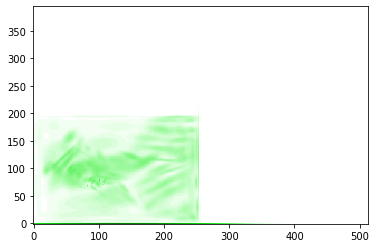

In [53]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(0, 2*l,delta),torch.linspace(0, 2*L, delta))
density = torch.exp(dif.log_density(grid)).reshape(delta,delta).T.cpu().detach()
plt.pcolormesh(torch.linspace(0, 2*l,delta),torch.linspace(0, 2*L, delta), density, cmap=green_cmap,shading='auto')

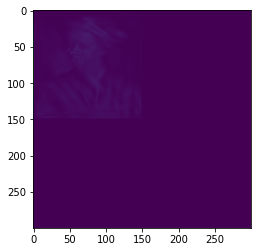

In [54]:
plt.imshow(density.T)

In [41]:
print(density.shape)

torch.Size([199, 258])


In [45]:
samples = dif.sample_model(1000)

In [ ]:
plt.scat